<a href="https://colab.research.google.com/github/mmdrez4/ProfileMatching/blob/main/face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cd MyDrive/'Colab Notebooks'/datasets/
!ls

drive  sample_data


In [ ]:
pip install facenet_pytorch

     |████████████████████████████████| 1.9 MB 4.1 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

workers = 0 if os.name == 'nt' else 4

Populating the interactive namespace from numpy and matplotlib


#### Determine if an nvidia GPU is available

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [ ]:
cd all_images/

[Errno 2] No such file or directory: 'all_images/'
/content


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd all_images/

/content/drive/My Drive/all_images


In [ ]:
!ls

all  images  instagram	twitter  twitter_bio_profileLink.csv


In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.


In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Face detected with probability: 0.999999
Face detected with probability: 0.998759
Face detected with probability: 0.999994
Face detected with probability: 0.992183
Face detected with probability: 0.999889
Face detected with probability: 0.999952
Face detected with probability: 0.998404
Face detected with probability: 0.998649
Face detected with probability: 0.999997
Face detected with probability: 0.999864
Face detected with probability: 0.995644
Face detected with probability: 0.999958
Face detected with probability: 0.993110
Face detected with probability: 1.000000
Face detected with probability: 0.990958
Face detected with probability: 0.999983
Face detected with probability: 0.999992
Face detected with probability: 0.987325
Face detected with probability: 0.999399
Face detected with probability: 0.942247
Face detected with probability: 0.993067
Face detected with probability: 0.999890
Face detected with probability: 0.859619
Face detected with probability: 0.999715


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                           instagram-CILLIZZAC  ...  twitter-o08km8yB_normal
instagram-CILLIZZAC                   0.000000  ...                 1.325226
instagram-aaronthespartan             1.371163  ...                 1.461280
instagram-abender_xo                  1.450757  ...                 1.162049
instagram-achelthegreat               1.547142  ...                 1.418785
instagram-aimeecho                    1.412625  ...                 1.601887
instagram-anaejaaa_                   1.474746  ...                 1.373490
instagram-annecutler                  1.458985  ...                 1.496802
instagram-auarthistory                1.432768  ...                 1.248513
instagram-bdoggy25                    1.312631  ...                 1.166821
instagram-beetut3                     1.593312  ...                 1.501690
instagram-bigdaddidro                 1.478219  ...                 1.375349
instagram-booyou                      1.366865  ...                 1.141912

In [ ]:
distances = torch.norm(embeddings[0] - embeddings[4])
print(distances, names[0], names[4])

tensor(1.4126) instagram-CILLIZZAC instagram-aimeecho


In [ ]:
x = names[0].startswith("instagram-")
# x = names[0].startswith("twitter-")

print(x)

True


In [ ]:
names[0]

'instagram-CILLIZZAC'

In [ ]:
def plotImages(path1, path2):
  image1 = plt.imread(path1)
  image2 = plt.imread(path2)

  plt.figure(1)
  plt.subplot(211)
  plt.imshow(image1)

  plt.subplot(212)
  plt.imshow(image2)
  plt.show()

twitter-EA5XFRYX_normal & instagram-aimeecho | distance = 0.991887629032135


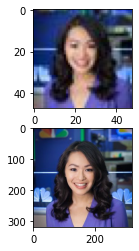

twitter-o08km8yB_normal & instagram-booyou | distance = 1.1419121026992798


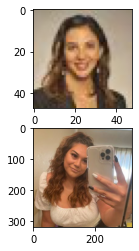

In [ ]:
matches = {}
dis = {}
threshold = 1.15
for index1, name1 in enumerate(names):
  if name1.startswith("twitter-"):
    for index2, name2 in enumerate(names):
      if name2.startswith("instagram-"):
        distance = torch.norm(embeddings[index1] - embeddings[index2])
        if(distance < threshold):
          if name1 in dis:
            if distance < dis[name1]:
              matches[name1] = name2
              dis[name1] = distance
          else:
            matches[name1] = name2
            dis[name1] = distance

# print(matches)
# print(dis)

for key, value in matches.items():
  print('{} & {} | distance = {}'.format(key, value,dis[key].cpu().detach().numpy() ))
  image1 = os.listdir(key)
  image2 = os.listdir(value)

  path1 = key + '/' +image1[0]
  path2 = value + '/' + image2[0]

  plotImages(path1, path2)